In [1]:
!pip install shap

     |████████████████████████████████| 266kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376823 sha256=a75a52eba70e549bee6cb2b4adeb93cff5a6d28ea10b241aa9dd5104a6d81b89
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from tensorflow.examples.tutorials.mnist import input_data

#import data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
#import modules
import sys
import tensorflow as tf
from PIL import Image,ImageFilter
import shap

In [0]:
def imageprepare(argv):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255)) #creates white canvas of 28x28 pixels
    
    if width > height: #check which dimension is bigger
        #Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0/width*height),0)) #resize height according to ratio width
        if (nheight == 0): #rare case but minimum is 1 pixel
            nheight = 1
        # resize and sharpen
        img = im.resize((20,nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight)/2),0)) #caculate horizontal pozition
        newImage.paste(img, (4, wtop)) #paste resized image on white canvas
    else:
        #Height is bigger. Heigth becomes 20 pixels. 
        nwidth = int(round((20.0/height*width),0)) #resize width according to ratio height
        if (nwidth == 0): #rare case but minimum is 1 pixel
            nwidth = 1
         # resize and sharpen
        img = im.resize((nwidth,20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth)/2),0)) #caculate vertical pozition
        newImage.paste(img, (wleft, 4)) #paste resized image on white canvas
    
    #newImage.save("sample.png")

    tv = list(newImage.getdata()) #get pixel values
    
    #normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [ (255-x)*1.0/255.0 for x in tv] 
    i =np.asarray(tva) 
    i=i.reshape(1,len(tva))
    return i
    #print(tva)

In [0]:
def predictint_layerwise(imvalue):
    """
    This function returns the predicted integer.
    The input is the pixel values from the imageprepare() function.
    """
    
    # Define the model (same as when creating the model file)
    x = tf.placeholder(tf.float32, [None, 784])
    W = tf.Variable(tf.zeros([784, 10]))
    b = tf.Variable(tf.zeros([10]))
    y = tf.nn.softmax(tf.matmul(x, W) + b)

    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    """
    Load the model.ckpt file
    file is stored in the same directory as this python script is started
    Use the model to predict the integer. Integer is returend as list.
    Based on the documentatoin at
    https://www.tensorflow.org/versions/master/how_tos/variables/index.html
    """
    with tf.Session() as sess:
        sess.run(init_op)
        saver.restore(sess, "/content/drive/My Drive/model2/model.ckpt")  
        ops_list = tf.get_default_graph().get_operations()
        tensors_list2 = [tensor for op in ops_list for tensor in op.inputs]
        print(tensors_list2)
        tensors_list1 = [tensor for op in ops_list for tensor in op.outputs]
        print(tensors_list1)
        to_explain = mnist.test.images[1:3]
        IN = tf.get_default_graph().get_tensor_by_name('Placeholder:0')
        OUT = tf.get_default_graph().get_tensor_by_name('Softmax:0')
        tensor_dict = {}
        tensor_dict['IN'] = IN
        tensor_dict['OUT'] = OUT
        #only_image = sess.run(tensor_dict,feed_dict={x: [imvalue]})
        #new_dict = sess.run(tensor_dict, feed_dict={x: mnist.test.images})
        #print(new_dict)
        e = shap.GradientExplainer((IN, OUT),mnist.test.images[0:2000],sess)
        shap_values = e.shap_values([imvalue],nsamples=200, ranked_outputs=2)
        #shap_values, indexes = e.shap_values(new_dict, ranked_outputs=2)       
        return shap_values

In [0]:
def predictint_layerwise(imvalue,model_path):
    """
    This function returns the predicted integer.
    The input is the pixel values from the imageprepare() function.
    """
    tf.reset_default_graph()
    # Define the model (same as when creating the model file)
    x = tf.placeholder(tf.float32, [None, 784])
    W = tf.Variable(tf.zeros([784, 10]))
    b = tf.Variable(tf.zeros([10]))
    y = tf.nn.softmax(tf.matmul(x, W) + b)

    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    """
    Load the model.ckpt file
    file is stored in the same directory as this python script is started
    Use the model to predict the integer. Integer is returend as list.
    Based on the documentatoin at
    https://www.tensorflow.org/versions/master/how_tos/variables/index.html
    """
    with tf.Session() as sess:
        sess.run(init_op)
        saver.restore(sess, model_path)
        IN = tf.get_default_graph().get_tensor_by_name('Placeholder:0')
        OUT = tf.get_default_graph().get_tensor_by_name('Softmax:0')
        e = shap.GradientExplainer((IN, OUT),mnist.test.images[0:2000],sess)
        shap_values = e.shap_values(imvalue,nsamples=200, ranked_outputs=2)
        return shap_values

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/model2/model.ckpt


Using TensorFlow backend.


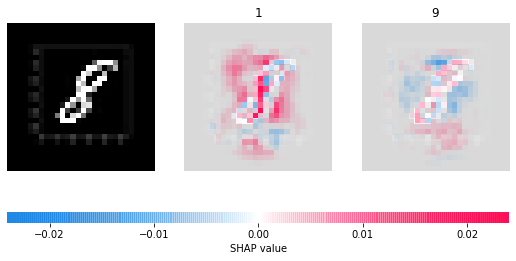

In [15]:
import numpy as np

imvalue = imageprepare("/content/1.png")
shap_values=predictint_layerwise(imvalue,"/content/drive/My Drive/model2/model.ckpt")
reshaped_value=[]
for x in shap_values[0]:
    reshaped_value.append(x.reshape(x.shape[0], 28, 28,1))
img_reshaped = imvalue.reshape(1,28,28,1)
shap.image_plot(reshaped_value,img_reshaped,shap_values[1])

In [0]:
shap_values[1]

0.0

In [0]:
import numpy as np
i =np.asarray(shap_values) 
k=i.reshape(28,28,1)

In [0]:
j=[]
for x in shap_values[0]:
  k = x.reshape(x.shape[0], 28, 28,1)  
  j.append(k)
  

TypeError: ignored

In [0]:
i = mnist.test.images.reshape(mnist.test.images.shape[0], 28, 28,1) 
print(i.shape)

(10000, 28, 28, 1)


In [0]:
shap.image_plot(j,i[1:2],k[1])

IndexError: ignored

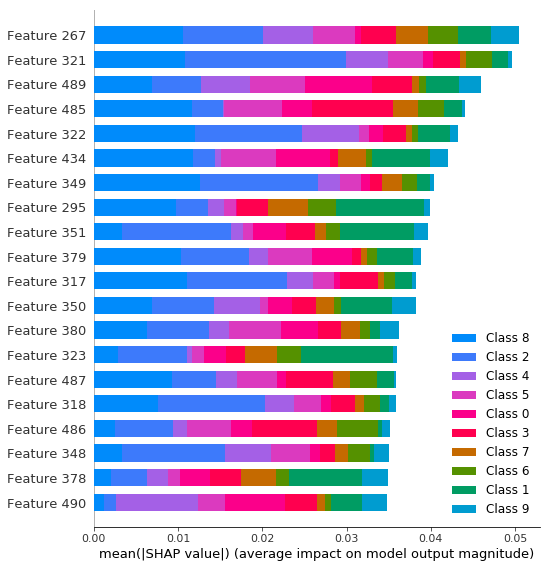

In [0]:
# summarize the effects of all the features
shap.summary_plot(shap_values,mnist.test.images[1:5])

In [0]:

def predictint(imvalue):
    """
    This function returns the predicted integer.
    The input is the pixel values from the imageprepare() function.
    """
    
    # Define the model (same as when creating the model file)
    x = tf.placeholder(tf.float32, [None, 784])
    W = tf.Variable(tf.zeros([784, 10]))
    b = tf.Variable(tf.zeros([10]))
    y = tf.nn.softmax(tf.matmul(x, W) + b)

    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    """
    Load the model.ckpt file
    file is stored in the same directory as this python script is started
    Use the model to predict the integer. Integer is returend as list.
    Based on the documentatoin at
    https://www.tensorflow.org/versions/master/how_tos/variables/index.html
    """
    with tf.Session() as sess:
        sess.run(init_op)
        saver.restore(sess, "/content/drive/My Drive/model2/model.ckpt")
        #print ("Model restored.")
        ops_list = tf.get_default_graph().get_operations()
        tensors_list2 = [tensor for op in ops_list for tensor in op.inputs]
        print(tensors_list2)
        tensors_list1 = [tensor for op in ops_list for tensor in op.outputs]
        print(tensors_list1)
        prediction=tf.argmax(y,1)
        k= prediction.eval(feed_dict={x: [imvalue]}, session=sess)
        IN = tf.get_default_graph().get_tensor_by_name('Placeholder:0')
        OUT = tf.get_default_graph().get_tensor_by_name('Softmax:0')
        e = shap.GradientExplainer((IN,OUT),mnist.test.images[0:2000],sess)
        shap_values = e.shap_values(mnist.test.images[1:5])
        print(shap_values[0].shape)
        # plot the feature attributions
        #shap.image_plot(shap_values, -mnist.test.images[1:5])
        return k,shap_values